### 1. Context ###

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

### 2. Attribute Information: ###


1. **age**: in years

2. **sex**: (1 = male; 0 = female)

3. **cp**: chest pain type 
    * Value 0: typical angina
    * Value 1: atypical angina
    * Value 2: non-anginal pain
    * Value 3: asymptomatic 

4. **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)

5. **chol**: serum cholestoral in mg/dl

6. **fbs**: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

7. **restecg**: resting electrocardiographic results
    * Value 0: normal
    * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria 

8. **thalach**: maximum heart rate achieved

9. **exang**: exercise induced angina (1 = yes; 0 = no)

10. **oldpeak**: ST depression induced by exercise relative to rest

11. **slope**: the slope of the peak exercise ST segment
    * Value 0: upsloping
    * Value 1: flat
    * Value 2: downsloping 

12. **ca**: number of major vessels (0-3) colored by flourosopy

13. **thal**: 
    * Value 3 : normal
    * Value 6 : fixed defect
    * Value 7 : reversable defect

14. **target**: 
    * Value 0 : not target
    * Value 1 : target

### 3. Preparation ###

In [28]:
# import necessary packages here
import pandas as pd
import numpy as np

# Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble
import xgboost as xgb

# Common Model Helpers
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection, model_selection, metrics

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix

import scikitplot
from scikitplot.metrics import plot_cumulative_gain

import shap

# yellowbrick
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve, FeatureImportances
from yellowbrick.features import RFECV, ParallelCoordinates

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
plt.style.use('ggplot')
sns.set_style('whitegrid')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### 4. Gather Data

In [2]:
import os
import zipfile
from urllib.request import urlretrieve

HEART_URL = 'https://www.kaggle.com/ronitf/heart-disease-uci/download'
filename = '33180_43520_bundle_archive.zip'

def get_heart_data(filename=filename, url=HEART_URL, force_download=False):
    if force_download or not os.path.exists(filename):
        urlretrieve(url, filename)
        print('Downloaded')
    
    zf = zipfile.ZipFile('C:/Users/kovus/Documents/Projects/heart_uci/data/heart-disease-uci.zip') 
    data = pd.read_csv(zf.open('heart.csv'))
    return data

In [4]:
data = get_heart_data()
data.head()

Downloaded


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
# make a copy of retrieved data
df = data.copy()

# take a look at first 5 rows
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### 5. Check Data

In [ ]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df)

In [6]:
# Are there any missing values?
print('There is(are) {} total missing values in dataset'.format(df.isnull().sum().sum()))

# Are there any duplicated samples?
print('There is(are) {} duplicated rows in dataset'.format(df.duplicated().sum()))

There is(are) 0 total missing values in dataset
There is(are) 1 duplicated rows in dataset


In [7]:
# make sure it is a duplicate
df.loc[df.duplicated(keep=False)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [8]:
# drop duplicated row
df.drop_duplicates(keep='first', inplace=True)

In [9]:
# preview information on features
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 35.4 KB


In [10]:
# statistical information on features
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### 6. Explore Data

### Imbalanced Classes

In [19]:
# how many unique values our features have?
pd.DataFrame({'Feature':df.nunique().index, 'Unique values':df.nunique().values})

,Feature,Unique values
0,age,41
1,sex,2
2,cp,4
3,trestbps,49
4,chol,152
5,fbs,2
6,restecg,3
7,thalach,91
8,exang,2
9,oldpeak,40


### 6.1 Categorical variables

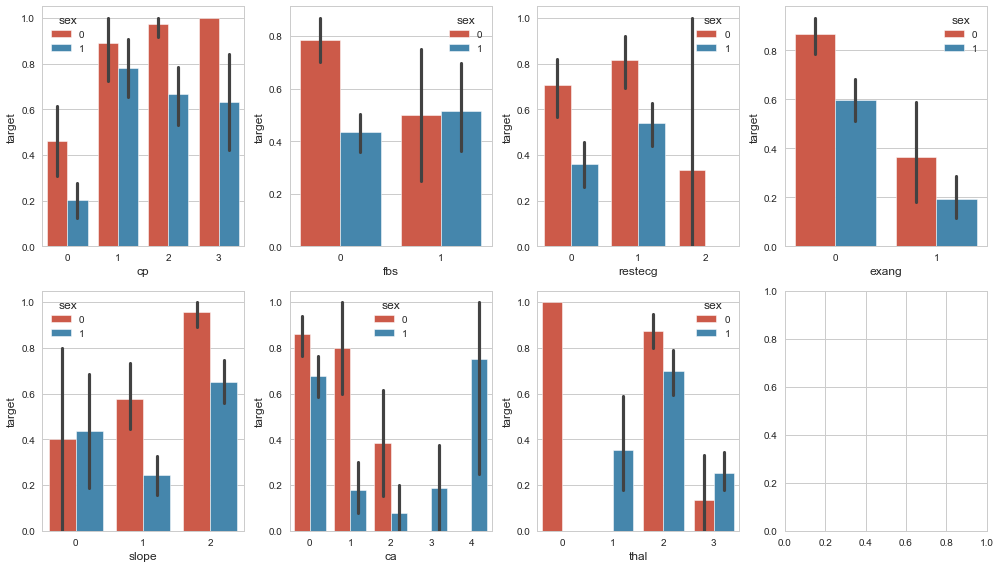

In [22]:
# graph individual features
fig, saxis = plt.subplots(2, 4, figsize = (14, 8))

# sns.barplot(x='sex', y='target', hue='sex', data=df, ax=saxis[0,0])
sns.barplot(x='cp', y='target', hue='sex', data=df, ax=saxis[0,0])
sns.barplot(x='fbs', y='target', hue='sex', data=df, ax=saxis[0,1])
sns.barplot(x='restecg', y='target', hue='sex', data=df, ax=saxis[0,2])
sns.barplot(x='exang', y='target', hue='sex', data=df, ax=saxis[0,3])
sns.barplot(x='slope', y='target', hue='sex', data=df, ax=saxis[1,0])
sns.barplot(x='ca', y='target', hue='sex', data=df, ax=saxis[1,1])
sns.barplot(x='thal', y='target', hue='sex', data=df, ax=saxis[1,2])

plt.tight_layout();

In [23]:
# categorical(discrete) variable correlation by using target
for col in cat_cols:
    print('Target Correlation by:', col)
    print(df[[col, 'target']].groupby(col).mean())
    print('-'*25, '\n')

Target Correlation by: sex
       target
sex          
0    0.750000
1    0.446602
------------------------- 

Target Correlation by: cp
      target
cp          
0   0.272727
1   0.820000
2   0.790698
3   0.695652
------------------------- 

Target Correlation by: fbs
       target
fbs          
0    0.548638
1    0.511111
------------------------- 

Target Correlation by: restecg
           target
restecg          
0        0.462585
1        0.629139
2        0.250000
------------------------- 

Target Correlation by: exang
         target
exang          
0      0.694581
1      0.232323
------------------------- 

Target Correlation by: slope
         target
slope          
0      0.428571
1      0.350000
2      0.751773
------------------------- 

Target Correlation by: ca
      target
ca          
0   0.742857
1   0.323077
2   0.184211
3   0.150000
4   0.750000
------------------------- 

Target Correlation by: thal
        target
thal          
0     0.500000
1     0.333333
2     

**Inference from Target Correlation:**

Assuming the sample **truly represents** the population :
- It is 69-82% likely that you have heart disease if you have **atypical angina, non-anginal pain asymptomatic chest pain**.
- Level of fasting blood sugar isn't indicative of a presence of heart disease.
- It is 63% likely that you have heart disease if your resting electrocardiographic result is **"having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)"**.
- It is 69% likely that you have heart disease if you **get execised induced angina**. 
- It is 75% likely that you have heart disease if the slope of the **peak exercise ST segment is downsloping**.
- It is 78-82% likely that you have heart disease if you downsloping 
- It is 78% likely that you have heart disease if your thal is of **fixed defect type**.

### 6.2 Continuous Variables

### Correlation

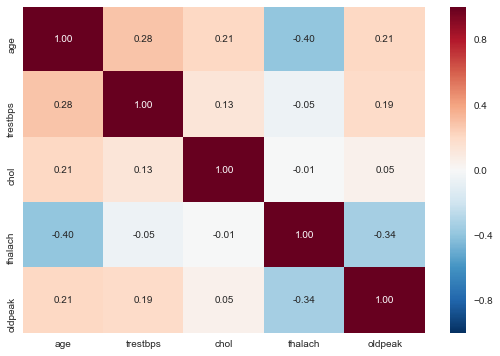

In [26]:
# correlation among ordinal(continuous) variables
fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(X.loc[:, ord_cols].corr(), fmt='.2f', annot=True, ax=ax, cmap='RdBu_r', vmin=-1, vmax=1);

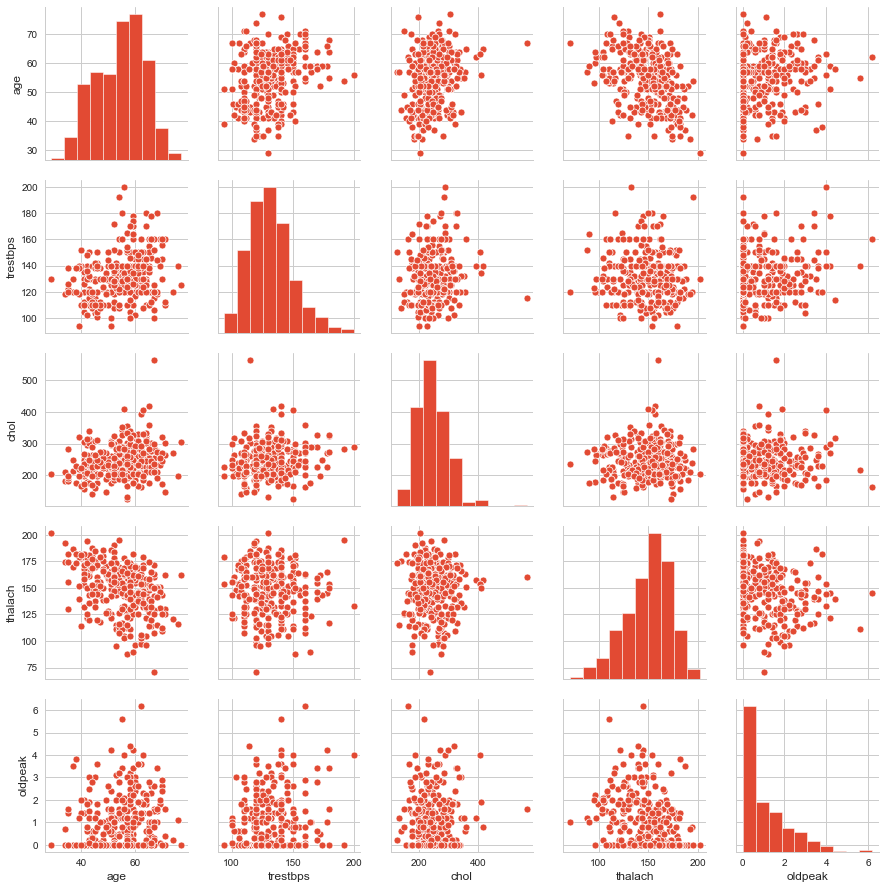

In [27]:
sns.pairplot(X.loc[:, ord_cols]);

**Inference from correlation charts:** 
- There seems to be a _weak negative correlation_ between age and maximum heart rate achieved.
- Looking at both correlation charts of continuous variables there seems to be **no strong correlation** between any two variables in the sample. **Thus, multicollinearity is highly unlikely**.

### Parallel Coordinates

Parallel Coordinates visualization makes it easy to see clusters of data in individual variables.

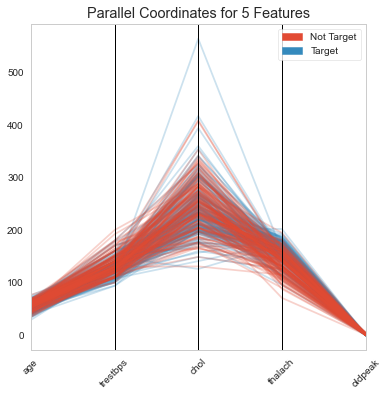

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))
pc = ParallelCoordinates(classes=['Not Target', 'Target'], features=ord_cols, alpha=0.25)
pc.fit(X[ord_cols], y)
pc.transform(X[ord_cols])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
pc.poof();

<Figure size 1152x720 with 0 Axes>

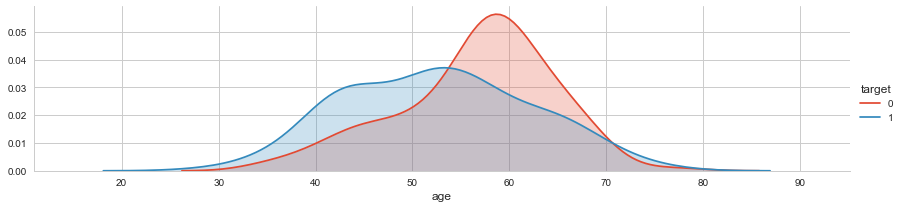

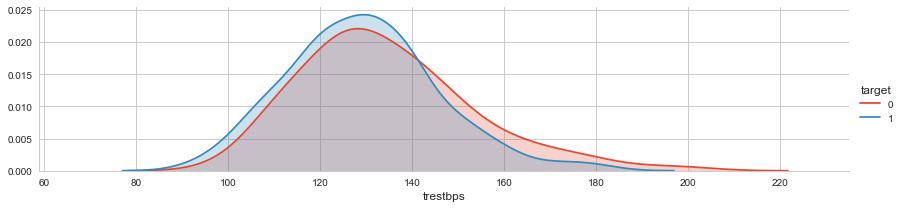

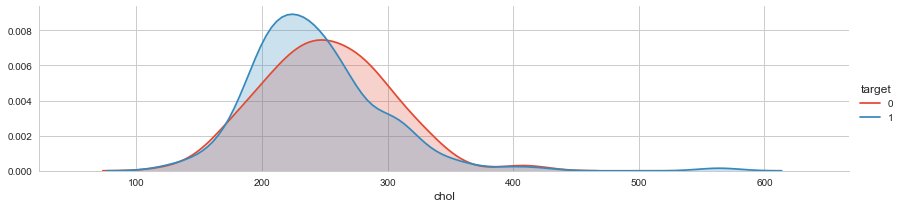

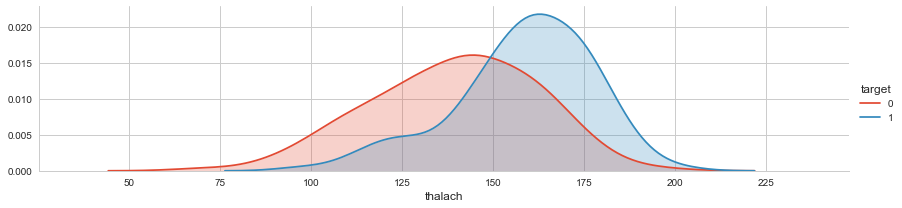

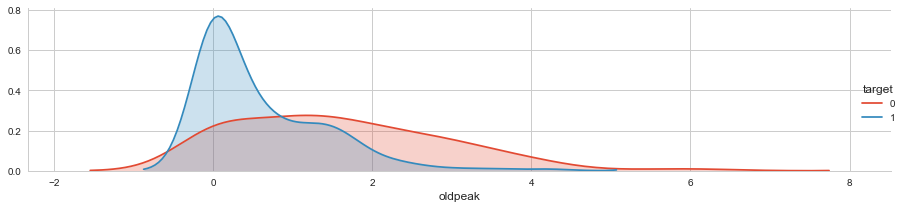

In [30]:
# graph distribution of ordinal(continuous) variables
plt.figure(figsize=(16, 10))
i = 0
for col in ord_cols:
    i += 1
    a = sns.FacetGrid(df, hue = 'target', aspect=4 )
    a.map(sns.kdeplot, col, shade= True )
    a.set(xlim=(df[col].min()-2*df[col].std() , df[col].max()+2*df[col].std()))
    a.add_legend()

plt.tight_layout();

**Inference:**

Parallel Coordinates visualization doesn't show any apparent clusters in any given variable. This is reinforced with distribuiton plots above.

Both target and non-target samples overlap each other in **Age, Resting blood pressure and Cholesterol plots**, meaning these variables are not really indicative of the presence of heart disease in a patient.

On the other hand, target and non-target samples in **"oldpeak = ST depression induced by exercise relative to rest" and "thalach = maximum heart rate achieved" plots** have slighlt different distribution.
- Patients with slighly higher maximum heart rate achieved are prone to having heart disease.
- Patients with oldpeak variable clustered around the mean are prone to having heart disease.

### Boxplots

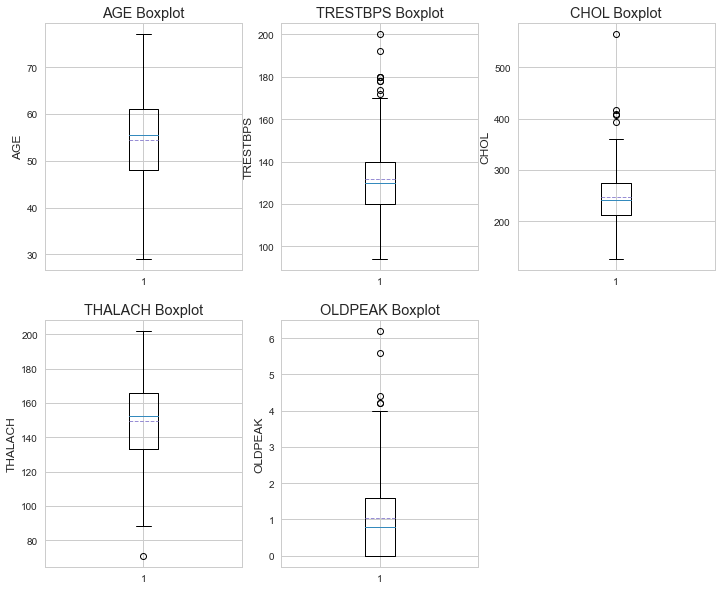

In [31]:
# boxplots for ordinal(continuous) variables
plt.figure(figsize=[12, 10])

i=0
for col in ord_cols:
    i += 1
    plt.subplot(230+i)
    plt.boxplot(x=df[col], showmeans = True, meanline = True)
    plt.title(f'{col.upper()} Boxplot')
    plt.ylabel(f'{col.upper()}')

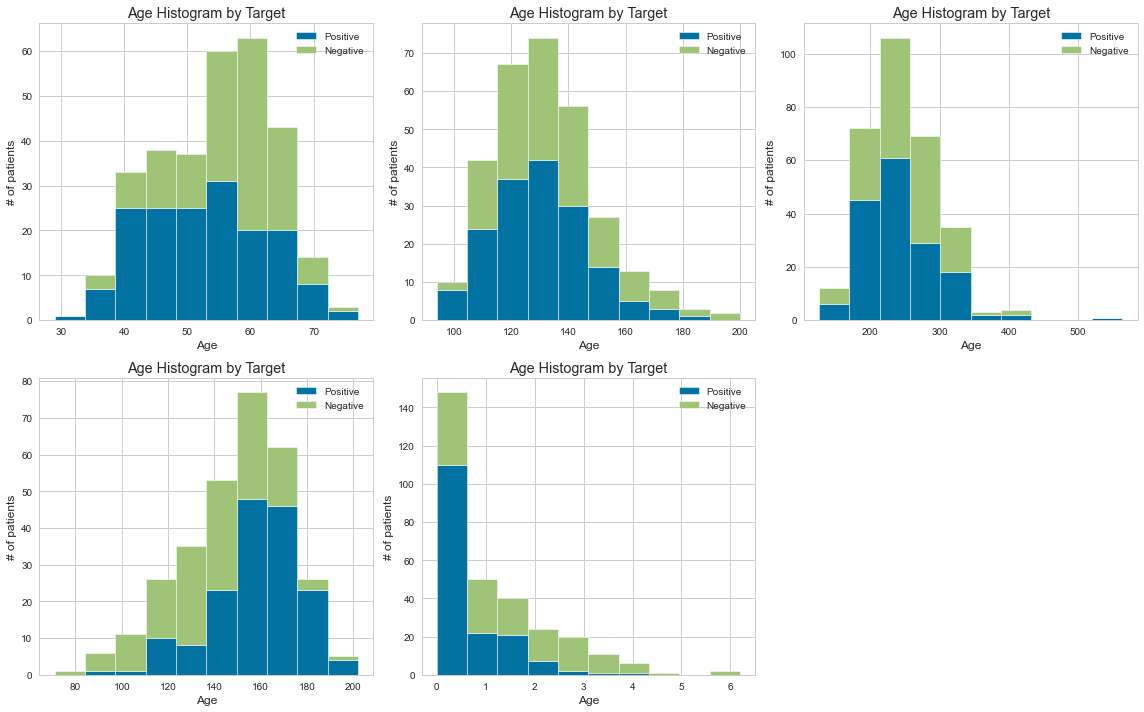

In [32]:
# graph distribution of ordinal(continuous) variables
plt.figure(figsize=(16, 10))
i = 0
for col in ord_cols:
    i += 1
    plt.subplot(230+i)
    plt.hist(x = [df[df['target']==1][col], df[df['target']==0][col]],
             stacked=True, color = ['b','g'],label = ['Positive','Negative'])
    plt.title('Age Histogram by Target')
    plt.xlabel('Age')
    plt.ylabel('# of patients')
    plt.legend();

plt.tight_layout();

### 7. Preprocess Data

In [33]:
# define target vector (y)
y = df['target']

# define features matrix (X)
X = df.drop('target', axis=1)

# look at the sizes of features matrix and target vector
print(f'X: {X.shape}, y: {y.shape}')

X: (302, 13), y: (302,)


In [34]:
# separate categorical features(discrete)
cat_cols = X.columns[X.nunique() <= 10]

# separate ordinal columns(continous)
ord_cols = X.columns[X.nunique() > 10]

print(f'Categorical features: {cat_cols.tolist()}\nOrdinal features: {ord_cols.tolist()}')

Categorical features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Ordinal features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [35]:
def get_sample_data(X=X, y=y):
    """Takes in X and y and performs the following:
    1. One-Hot Encodes(Dummy variables) categorical features
    2. Splits X and y into training and testing sets
    3. Standardizes features for better model performance
    4. Returns X_train, X_test, y_train, y_test
    
    Parameters:
    ----------
    X : Pandas DataFrame(default: user-defined feature matrix)
    y : Pandas Series(defalt: user-defined target vector)
    
    Returns:
    X_train: Pandas DataFrame, X training set
    X_test: Pandas DataFrame, X testing set
    y_train: Pandas Series, y training set
    y_test: Pandas Series, y testing set
    """

    # cast categorical features as type category
    for col in cat_cols:
        X = X.astype({col:'category'})

    # get dummy variables for categorical features
    X = pd.get_dummies(X, drop_first=True)
    
    # rename dummy columns
    X.rename(columns={'sex_1':'sex_male', 'fbs_1':'fbs_pos', 'exang_1':'exang_pos'}, inplace=True)
    
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=43)
    
    # standardize training and testing sets separately to avoid data leakage
    sca = StandardScaler()
    X_train.loc[:, ord_cols] = sca.fit_transform(X_train.loc[:, ord_cols])
    X_test.loc[:, ord_cols] = sca.transform(X_test.loc[:, ord_cols])
    
    return X_train, X_test, y_train, y_test

In [36]:
X_train, X_test, y_train, y_test = get_sample_data()
print(f'X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}')

X_train: (211, 22)
y_train: (211,)
X_test: (91, 22)
y_test: (91,)


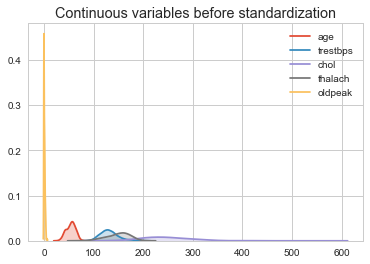

In [37]:
for col in ord_cols:
    sns.kdeplot(data=df[col], shade=True)
    plt.title('Continuous variables before standardization')

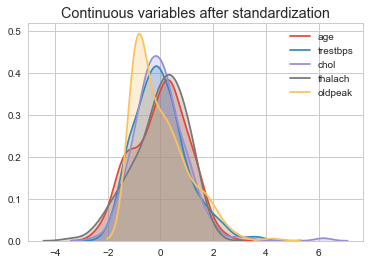

In [38]:
for col in ord_cols:
    sns.kdeplot(data=X_train[col], shade=True)
    plt.title('Continuous variables after standardization')

In [39]:
# concatenate training and testing set after normalization to avoid data leakage
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X.shape, y.shape

((302, 22), (302,))

## Model Building

### Baseline Model

As a baseline model we will utilize Dummy Classifier, which we will then use for comparison.

In [41]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
dc.fit(X_train, y_train)
dc.score(X_test, y_test)

0.3956043956043956

In [42]:
print('Precision score:', metrics.precision_score(y_test, dc.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, dc.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, dc.predict(X_test)))

Precision score: 0.4791666666666667
F1 score: 0.5825242718446602
Matthews score: 0.1083880412207675


### Various Families

We will take a look at different classifiers below:

In [43]:
for model in [DummyClassifier,
              linear_model.LogisticRegression,
              tree.DecisionTreeClassifier,
              neighbors.KNeighborsClassifier,
              naive_bayes.GaussianNB,
              svm.SVC,
              ensemble.RandomForestClassifier,
              xgb.XGBClassifier
             ]:
    classifier = model()
    kfold = model_selection.KFold(n_splits=10, random_state=43)
    score = model_selection.cross_val_score(classifier, X, y, scoring='roc_auc', cv=kfold)
    print(f'{model.__name__:25}'
          f'AUC: {score.mean():.3f} STD: {score.std():.3f}')

DummyClassifier          AUC: 0.549 STD: 0.108
LogisticRegression       AUC: 0.915 STD: 0.046
DecisionTreeClassifier   AUC: 0.725 STD: 0.066
KNeighborsClassifier     AUC: 0.867 STD: 0.074
GaussianNB               AUC: 0.883 STD: 0.088
SVC                      AUC: 0.892 STD: 0.061
RandomForestClassifier   AUC: 0.889 STD: 0.071
XGBClassifier            AUC: 0.859 STD: 0.071


Top 3 scorers are:
1. Logistic Regression
2. Support Vector Classifier
3. Random Forest Classifier

We will take a look at them in same order.

### Stacking

We will try out stacking and see if it improves the score.

In [44]:
from mlxtend.classifier import StackingClassifier

classifiers = [x() for x in [DummyClassifier,
                             linear_model.LogisticRegression,
                             tree.DecisionTreeClassifier,
                             neighbors.KNeighborsClassifier,
                             naive_bayes.GaussianNB,
                             svm.SVC,
                             ensemble.RandomForestClassifier,
                             xgb.XGBClassifier
                            ]
              ]

# meta_classifier???
stc = StackingClassifier(classifiers=classifiers, meta_classifier=linear_model.LogisticRegression())
score = model_selection.cross_val_score(stc, X, y, scoring='roc_auc', cv=kfold)
print(f'stc.__name__:'
      f'AUC: {score.mean():.3f} STD: {score.std():.3f}')

stc.__name__:AUC: 0.863 STD: 0.072


Stacking the classifiers didn't improve the score. We will not proceed with stacked classifier.

### Logistic Regression

In [45]:
logr = linear_model.LogisticRegression(random_state=43)
logr.fit(X_train, y_train)

LogisticRegression(random_state=43)

In [46]:
logr.score(X_test, y_test)

0.8901098901098901

In [47]:
print('Precision score:', metrics.precision_score(y_test, logr.predict(X_test)))
print('ROC_AUC score:', metrics.roc_auc_score(y_test, logr.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, logr.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, logr.predict(X_test)))

Precision score: 0.8571428571428571
ROC_AUC score: 0.8824390243902439
F1 score: 0.9056603773584904
Matthews score: 0.7822419312619275


In [48]:
# Feature importance
print('Feature Importances:')
for col, val in sorted(zip(X.columns, logr.coef_[0]),
                       key=lambda x: x[1],
                       reverse=True
                      ):
    print(f'{col:10}{val:10.3f}')

Feature Importances:
cp_2           1.326
cp_3           1.007
thal_2         0.798
slope_2        0.459
restecg_1      0.454
cp_1           0.394
thalach        0.345
ca_4           0.266
thal_1         0.165
restecg_2      0.137
age            0.019
fbs_pos        0.014
chol          -0.076
trestbps      -0.318
oldpeak       -0.453
slope_1       -0.491
thal_3        -0.637
sex_male      -0.652
ca_3          -0.776
exang_pos     -0.911
ca_1          -1.180
ca_2          -1.695


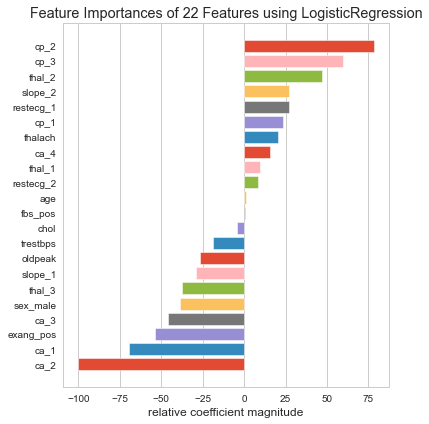

In [49]:
fig, ax = plt.subplots(figsize=(6, 6))
logr_fi = FeatureImportances(logr)
logr_fi.fit(X, y)
logr_fi.poof();

#### Classification Report

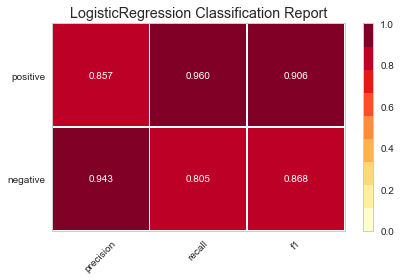

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))
logr_cr = ClassificationReport(logr, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
logr_cr.score(X_test, y_test)
logr_cr.poof();

#### Confusion Matrix

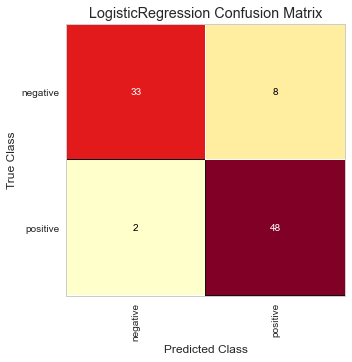

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))
logr_cm = ConfusionMatrix(logr, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
logr_cm.score(X_test, y_test)
logr_cm.poof();

#### ROC Curve

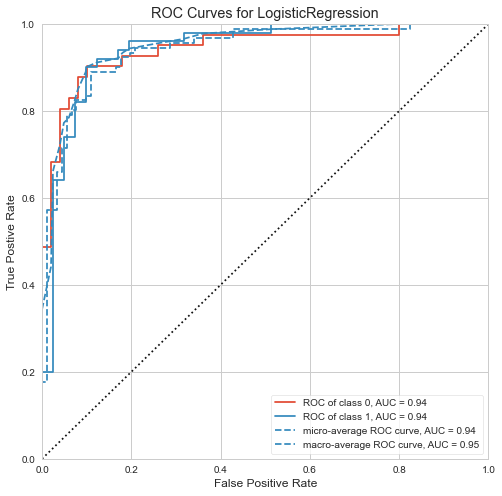

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
logr_roc = ROCAUC(logr)
logr_roc.score(X_test, y_test)
logr_roc.poof();

#### Learning Curve

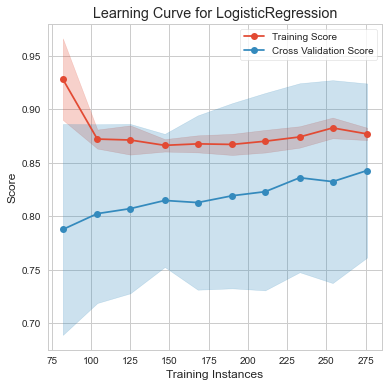

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = model_selection.StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
logr_lc = LearningCurve(logr, cv=cv, train_sizes=sizes, scoring='f1_weighted', n_jobs=-1, ax=ax)
logr_lc.fit(X, y)
logr_lc.poof();

**Inference:**

Learning curve shows us that our Logistic Regression Classifier is **performing quite well**. Difference between Training and Cross Validation Scores are minimizing with more data.

#### Cumulative Gains Plot

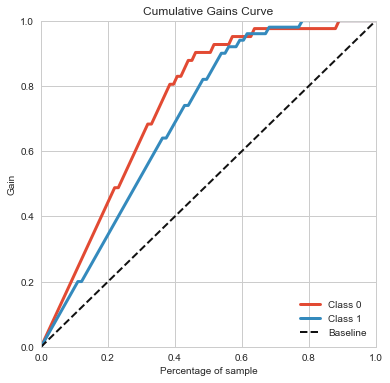

In [54]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = logr.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax);

**Inference:**

Cumulative Gains plot is used to evaluate a binary classifier. It models the true positive rate(sensitivity) agains the support rate(fraction of positive predictions.
This plot shows that if we ordered our patients by how likely they are to have heart disease, **if we took first 65% of them we would have 99% of sick patients.**

### Support Vector Classifier

In [55]:
svc = svm.SVC(random_state=43, probability=True)
svc.fit(X_train, y_train)

SVC(probability=True, random_state=43)

In [56]:
svc.score(X_test, y_test)

0.8571428571428571

In [57]:
print('Precision score:', metrics.precision_score(y_test, svc.predict(X_test)))
print('ROC_AUC score:', metrics.roc_auc_score(y_test, svc.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, svc.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, svc.predict(X_test)))

Precision score: 0.8245614035087719
ROC_AUC score: 0.8480487804878049
F1 score: 0.8785046728971964
Matthews score: 0.7159293322876372


#### Classification Report

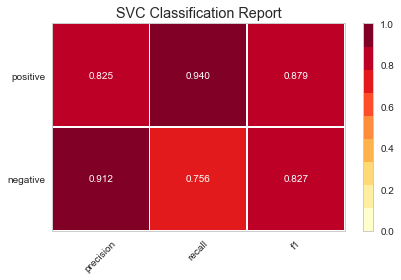

In [58]:
fig, ax = plt.subplots(figsize=(6, 4))
svc_cr = ClassificationReport(svc, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
svc_cr.score(X_test, y_test)
svc_cr.poof();

#### Confusion Matrix

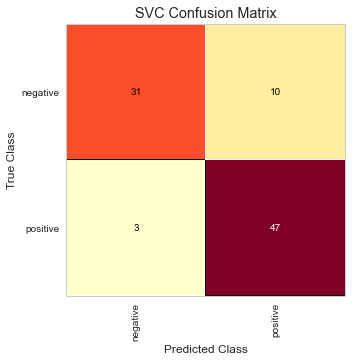

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
svc_cm = ConfusionMatrix(svc, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
svc_cm.score(X_test, y_test)
svc_cm.poof();

#### ROC Curve

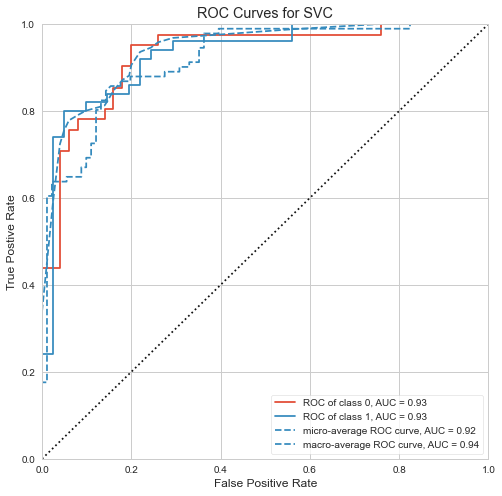

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))
svc_roc = ROCAUC(svc)
svc_roc.score(X_test, y_test)
svc_roc.poof();

#### Learning Curve

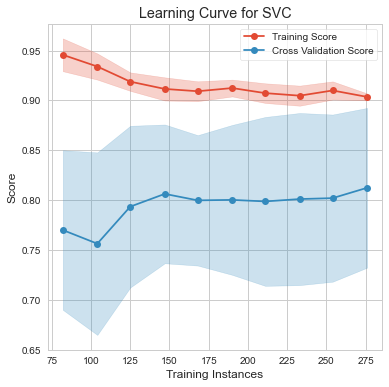

In [61]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = model_selection.StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
svc_lc = LearningCurve(svc, cv=cv, train_sizes=sizes, scoring='f1_weighted', n_jobs=-1, ax=ax)
svc_lc.fit(X, y)
svc_lc.poof();

**Inference:**

Learning curve shows us that our Support Vector Classifier is suffering from high variance(overfitting). Depending on the costs, **gathering more data** will likely improve the Cross Validation Score and prevent overfitting.

#### Cumulative Gains Plot

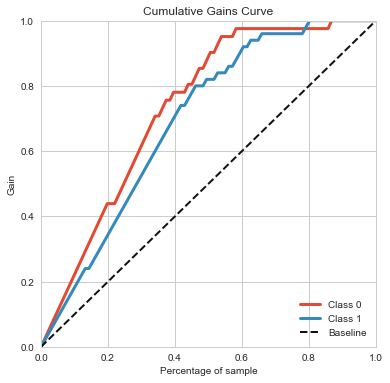

In [62]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = svc.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax);

**Inference:**

This plot shows that if we ordered our patients by how likely they are to have heart disease, **if we took first 65% of them we would have 98% of sick patients.**

### Random Forest Classifier

In [63]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=43)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=43)

In [64]:
rf.score(X_test, y_test)

0.8461538461538461

In [65]:
print('Precision score:', metrics.precision_score(y_test, rf.predict(X_test)))
print('ROC_AUC score:', metrics.roc_auc_score(y_test, rf.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, rf.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, rf.predict(X_test)))

Precision score: 0.8103448275862069
ROC_AUC score: 0.8358536585365853
F1 score: 0.8703703703703703
Matthews score: 0.6951620303856834


In [66]:
# Feature Importances
print('Feature Importances:')
for col, val in sorted(zip(X_train.columns, rf.feature_importances_),
                       key = lambda x: x[1],
                       reverse=True
                      ):
    print(f'{col:10} {val:10.3f}')

Feature Importances:
oldpeak         0.115
thalach         0.114
age             0.089
chol            0.086
trestbps        0.083
exang_pos       0.077
thal_2          0.074
thal_3          0.074
slope_2         0.048
slope_1         0.036
cp_2            0.033
sex_male        0.026
ca_2            0.024
cp_3            0.024
ca_1            0.024
restecg_1       0.024
cp_1            0.015
fbs_pos         0.012
ca_3            0.011
thal_1          0.006
ca_4            0.002
restecg_2       0.001


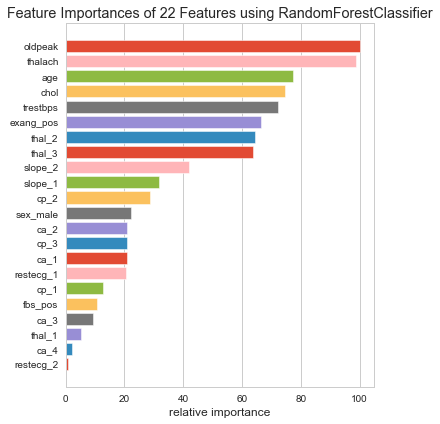

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))
rf_fi = FeatureImportances(rf)
rf_fi.fit(X, y)
rf_fi.poof();

### Optimize Model

Below we will tune hyperparameters of our Random Forest classifier and attempt to increase model's accuracy.

In [71]:
rf_test = ensemble.RandomForestClassifier(random_state=43)
params = {'max_features': [0.4, 'auto'],
          'n_estimators': [15, 200],
          'min_samples_leaf': [1, 0.1],
         }
cv = model_selection.GridSearchCV(rf, params, n_jobs=-1).fit(X_train, y_train)
print(cv.best_params_)

{'max_features': 'auto', 'min_samples_leaf': 0.1, 'n_estimators': 200}


In [78]:
rf_best = ensemble.RandomForestClassifier(**{'max_features': 'auto',
                                             'n_estimators': 200,
                                             'min_samples_leaf': 0.1,
                                             'random_state': 43
                                            })
rf_best.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=0.1, n_estimators=200, random_state=43)

In [79]:
print('Precision score:', metrics.precision_score(y_test, rf_best.predict(X_test)))
print('ROC_AUC score:', metrics.roc_auc_score(y_test, rf_best.predict(X_test)))
print('F1 score:', metrics.f1_score(y_test, rf_best.predict(X_test)))
print('Matthews score:', metrics.matthews_corrcoef(y_test, rf_best.predict(X_test)))

Precision score: 0.7741935483870968
ROC_AUC score: 0.8092682926829268
F1 score: 0.8571428571428571
Matthews score: 0.6604614585947888


Slight improvement of accuracy has been reached after hyperparameter tuning.

#### Classification Report

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
rf_cr = ClassificationReport(rf_best, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
rf_cr.score(X_test, y_test)
rf_cr.poof();

#### Confusion Matrix

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
cm_viz = ConfusionMatrix(rf_best, classes=['negative', 'positive'], label_encoder={0:'negative', 1:'positive'})
cm_viz.score(X_test, y_test)
cm_viz.poof();

#### ROC Curve

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
roc_viz = ROCAUC(rf_best)
roc_viz.score(X_test, y_test)
roc_viz.poof();

#### Learning Curve

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
cv = model_selection.StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(rf_best, cv=cv, train_sizes=sizes, scoring='f1_weighted', n_jobs=-1, ax=ax)
lc_viz.fit(X, y)
lc_viz.poof();

**Inference:**

Learning curve shows us that our Random Forest Classifier might be suffering from high bias(underfitting) since both Training and Cross Validation Scores are lower than Logistic Classifier's scores. Depending on the importance of ~5% accuracy, **more complex(polynomial features) models or using more features** might fix our underfitting problem.

#### Cumulative Gains Plot

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
y_probas = rf_best.predict_proba(X_test)
scikitplot.metrics.plot_cumulative_gain(y_test, y_probas, ax=ax);

**Inference:**

Cumulative Gains plot is used to evaluate a binary classifier. It models the true positive rate(sensitivity) agains the support rate(fraction of positive predictions.
This plot shows that if we ordered our patients by how likely they are to have heart disease, **if we took first 65% of them we would have 98% of sick patients.**

In [80]:
shap.initjs()

s = shap.TreeExplainer(rf_best)
shap_vals = s.shap_values(X_test)
shap.force_plot(s.expected_value[0],
                shap_vals[0][3, :],
                feature_names=X.columns
               )


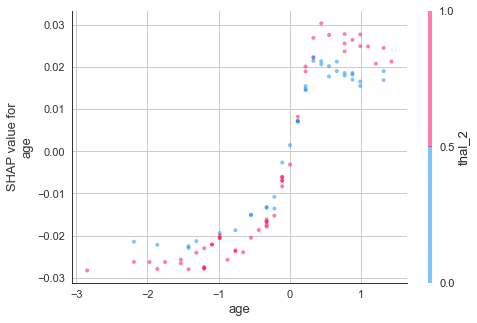

In [81]:
shap.dependence_plot('age',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

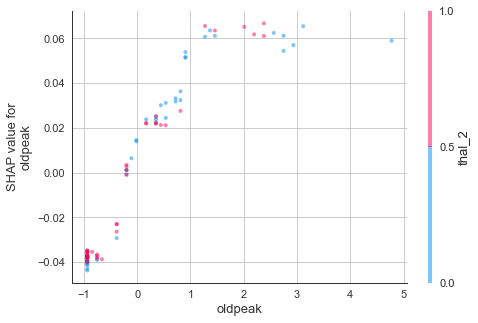

In [82]:
shap.dependence_plot('oldpeak',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

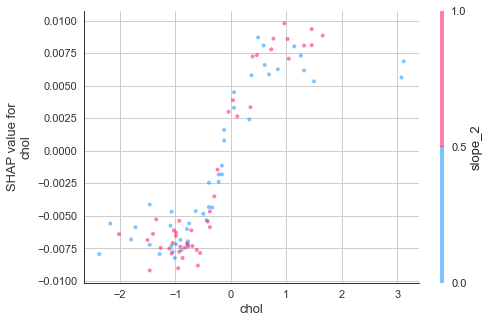

In [83]:
shap.dependence_plot('chol',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

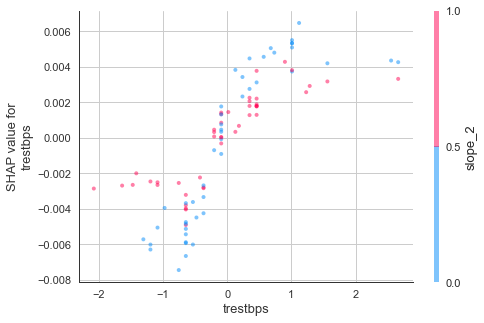

In [84]:
shap.dependence_plot('trestbps',
                     shap_vals[0],
                     X_test,
                     feature_names=X_test.columns,
                     alpha=0.5
                    )

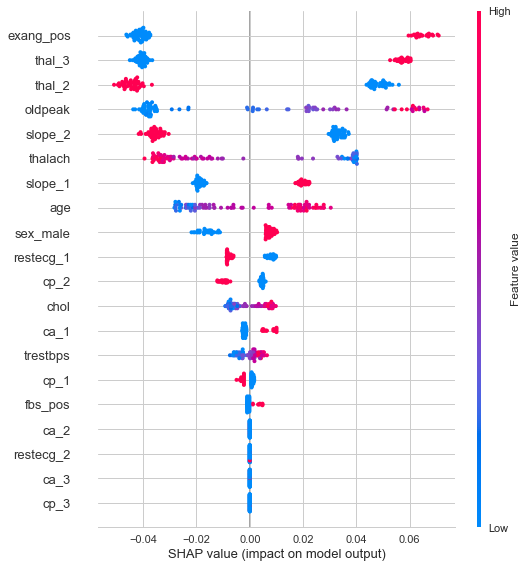

In [85]:
shap.summary_plot(shap_vals[0], X_test)

### Feature Selection

### RFE

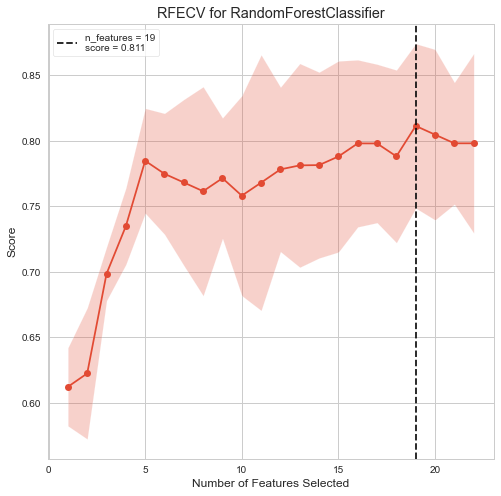

In [86]:
fig, ax = plt.subplots(figsize=(8 ,8))
rfe = RFECV(ensemble.RandomForestClassifier(n_estimators=100), cv=5)
rfe.fit(X, y)
rfe.poof();

In [88]:
rfe.rfe_estimator_.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1])

In [89]:
rfe.rfe_estimator_.n_features_

19

In [90]:
X.columns[rfe.rfe_estimator_.support_]

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_male', 'cp_1',
       'cp_2', 'cp_3', 'fbs_pos', 'restecg_1', 'exang_pos', 'slope_1',
       'slope_2', 'ca_1', 'ca_2', 'ca_3', 'thal_2', 'thal_3'],
      dtype='object')

**Inference:**

Recursive Feature Elimination showed that **19 out of 22 features we have in our dataset are essential in predicting the outcome.** Thus, we cannot drop them.